In [517]:
import numpy as np
from scipy.stats import ortho_group # для создания случаной ортогональной матрицы
import random
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm # для замера времени

## 1. Функция создания квадратичной функции

Будем рассматривать квадратичную задачу:
$$f(x)=\frac{1}{2}\langle Ax,x\rangle-\langle b,x\rangle\longrightarrow min_{x\in \mathbb{R}^d}~,$$
где $A$ - симметричная матрица $d\times d$, $b\in  \mathbb{R}^d$. 
Такие задачи являются гладкими: константа $L$ - максимальное с.з. матрицы A. Поэтому на этом примере будем тестировать метод `FFD` аппроксимации градиента. Задачи будем сэмплить следующим образом: вначале создаем случайную ортогональную матрицу $O\in \mathbb{R}^{d\times d}$, далее создаем диагональную матрицу $Diag\in \mathbb{R}^{d\times d}$, где максимальное с.з. на диагонали равно константе $L$, одна половина с.з. имеют близкие к $L$ значения, а остальные с.з. малы. После этого получаем симметричную матрицу $A=O^T\cdot Diag\cdot O$ с максимальным с.з., равным $L$. Далее получаем вектор $b=Ax^*$, где $x^*$ - требуемое решение задачи. Таким образом, получаем задачу с известными заранее требуемыми:
1. константой Липшица градиента $L$.
2. $x^*$ - оптимумом функции $f(x)$.

In [375]:
def quad_coefs(d, L, random_state=None, x_solution=None):
    O = ortho_group.rvs(d, random_state=random_state) # создание рандомной ортогональной матрицы d на d
    eigenvals = []
    for i in range(d):
        if i%2 == 0:
            eigenval = L / (1 + (1/d) * i) # половина с.з. близка к константе L
        else:
            eigenval = 1 / (1 + (1/d) * i) # половина с.З близка к 0
        eigenvals.append(eigenval)
    
    eigenvals = np.array(eigenvals)
    # eigenvals = np.random.shuffle(eigenvals) # возможно не надо
    
    Diag = np.eye(d) # создаем и заполняем диагональную матрицу с.з.
    for i in range(d):
        Diag[i,i] = eigenvals[i]
    
    A = O.T @ Diag @ O # создаем матрицу при квадратичном члене
    
    if x_solution == None:
        x_solution = np.ones((d,1)) # если желаемое решение задачи не получено, создаем его из единиц
    
    b = A @ x_solution # создаем вектор при линейной члене
    
    return A, b
    
    

## 2. Реализация класса quadratic

In [1426]:
class quadratic():
    def __init__(self, A, b, L, m=0):
        self.A = A # матрица при квадратичном члене функции
        self.b = b # вектор при линейном члене функции
        self.L = L # константа Липшица градиента
        self.dim = A.shape[0] # размерность задачи
        self.m = m # конечная метка мантиссы
        self.gamma = None
    
    # выдает значение функции в точке
    def func(self, x):
        z = x[:,None] # превращаем строку в вектор для удобства вычислений
        return ((z.T @ self.A @ z)/2 - (self.b).T @ z)[0,0]
    
    # выдает зашумленное значение функции путем округления до self.m значащих цифр
    def noised_func(self, x):
        return np.around(self.func(x), self.m) # округляем до конечной мантиссы m значение func(x)
    
    # выдает аналитический градиент функции
    def grad(self, x):
        z = x[:,None] # превращаем строку в вектор для удобства вычислений
        return (A @ z - b).flatten()
    
    # finite forward difference
    def FFD(self, x):
        delta = 10 ** (-self.m) # размер шума
        gamma = (4 * delta / self.L) ** (0.5)
        g = np.zeros(self.dim) 
        for i in range(self.dim):
            x_gamma = x.copy()
            x_gamma[i] += gamma
            g[i] = (self.noised_func(x_gamma) - self.noised_func(x)) / gamma
        
        return g # возвращаем аппроксимацию градиента
    
    # finite central difference
    def FCD(self, x):
        g = np.zeros(self.dim) 
        for i in range(self.dim):
            x_gamma_1 = x.copy()
            x_gamma_2 = x.copy()
            x_gamma_1[i] += self.gamma
            x_gamma_2[i] -= self.gamma
            g[i] = (self.noised_func(x_gamma_1) - self.noised_func(x_gamma_2)) / (2*self.gamma)
        
        return g # возвращаем аппроксимацию градиента
    
    # forward wise component
    def FWC(self, x):
        delta = 10 ** (-self.m) # размер шума
        gamma = (4 * delta / self.L) ** (0.5)
        g = np.zeros(self.dim) 
        i = np.random.randint(self.dim) # пикаем рандомную координату, чтобы посчитать по этому напр. пр-ую
        x_gamma = x.copy()
        x_gamma[i] += gamma
        g[i] = self.dim * (self.noised_func(x_gamma) - self.noised_func(x)) / gamma
        
        return g # возвращаем аппроксимацию градиента
    
    
    # central wise component
    def CWC(self, x):
        g = np.zeros(self.dim) 
        i = np.random.randint(self.dim) # пикаем рандомную координату, чтобы посчитать по этому напр. пр-ую
        x_gamma_1 = x.copy()
        x_gamma_2 = x.copy()
        x_gamma_1[i] += self.gamma
        x_gamma_2[i] -= self.gamma
        g[i] = self.dim * (self.noised_func(x_gamma_1) - self.noised_func(x_gamma_2)) / (2*self.gamma)
        
        return g # возвращаем аппроксимацию градиента
    
    # forward sphere smoothed gradients
    def FSSG2(self, x):
        delta = 10 ** (-self.m) # размер шума
        gamma = (self.dim * delta / self.L) ** (0.5)
        
        e = np.random.randn(self.dim)
        e /= np.linalg.norm(e)
        x_gamma = x.copy()
        x_gamma += gamma * e
        g = (self.dim * (self.noised_func(x_gamma) - self.noised_func(x)) / gamma) * e
        
        return g # возвращаем аппроксимацию градиента
    
    def CSSG2(self, X):
        e = np.random.randn(self.dim)
        e /= np.linalg.norm(e)
        x_gamma_1 = x.copy()
        x_gamma_2 = x.copy()
        x_gamma_1 += self.gamma * e
        x_gamma_2 -= self.gamma * e
        g = (self.dim * (self.noised_func(x_gamma_1) - self.noised_func(x_gamma_2)) / (2*self.gamma)) * e
        
        return g # возвращаем аппроксимацию градиента

Также напишем функции, реализующие процедуру градиентного спуска `GD` и процедуру адаптивного градиентного спуска `AGD` по заданным функцие(по факту это `RMSProp`), способе вычисления производной, константе Липшица градиента и количеству итераций(по дефолту max_iters=1000):

In [1387]:
def GD(f, g, x, h, max_iters=1000, mean=False):
    x_ = x.copy()
    x_summa = x_.copy()
    values = []
    for i in range(max_iters):
        if mean == False:
            values.append(f(x_))
        else:
            values.append(f(x_summa/(i+1)))
        x_ -= h * g(x_)
        x_summa += x_
    return np.array(values)

In [1043]:
def AGD(f, g, x, lr, gamma, max_iters=1000):
    eps = 0.01
    x_ = x.copy()
    values = []
    acc = 0
    for i in range(max_iters):
        values.append(f(x_))
        grad = g(x_)
        acc = gamma * acc + (1 - gamma) * np.linalg.norm(grad)**2
        x_ -= lr * grad / (acc**(0.5) + eps)
    return np.array(values)

Во всех экспериментах будут сэмплироваться задачи с точкой оптимума $x^*=(1,1,...,1)^T\in \mathbb{R}^d$. Поэтому параметр нормы точки оптимума $R$, который используется для связи невязки по функции и по норме градиента будет равен: $R=\Vert (1,1,...,1)^T\Vert=\sqrt{d}$. Тогда теоретическая зависимость для метода `FFD` будем иметь вид:
$$\varepsilon \sim 2R\sqrt{dL\Delta}=2d\sqrt{L\Delta}$$

Напишем функцию, реализующую теоретическую зависимость невязки по функции для методов `FFD` и `FWC`:

In [1357]:
def experimental_FFD_FWC(delta, L, d):
    return 2 * d * (L * delta) ** 0.5

## 3. Исследование FFD

### 3.1. Зависимость $\varepsilon (m)$.

Будем исследовать зависимость при размерности пространства $d=100$, константе Липшица градиента $L=20$, точку решения задачи $x^*=(1,1,...,1)^T$, меняя при этом метку конечной мантиссы в пределе: $m=\overline {1,8}$, на методе `FFD` (конечная прямая разность). Стартовую точку будем сэмплить случайно из равномерного распределения на интервале $[-10,10]$.

Вначале создадим коэффициенты, удовлетворяющие условию выше, после этого по ним создадим квадратичную задачу:

In [1452]:
d = 100 # размерность пространства
L = 20 # константа Липшица
random_state = 1

In [1453]:
A, b = quad_coefs(d, L)
prob = quadratic(A, b, L)

Зная точку оптимума задачи, найдем оптимум для дальнейшего построения графиков:

In [1454]:
x_solution = np.ones(d)
prob_solution = prob.func(x_solution)
print('Оптимум задачи:', prob_solution)

Оптимум задачи: -322.79144286367074


Теперь сэмплируем рандомную стартовую точку:

In [1455]:
x_start = np.random.uniform(-10, 10, d) # стартовую точку выбираем из равномерного распределения от -10 до 10

Запустим процедуру GD для аналитической производной, и для конечной прямой суммы при различных значениях метки мантиссы, после чего построим графики:

In [1456]:
max_iters=500
prob_values = []

values = GD(prob.func, prob.grad, x_start, 1/L, max_iters)
prob_values.append(values)

for i in trange(1,9):
    prob.m = i
    values = GD(prob.func, prob.FFD, x_start, 1/L, max_iters)
    prob_values.append(values)


  0%|          | 0/8 [00:00<?, ?it/s]

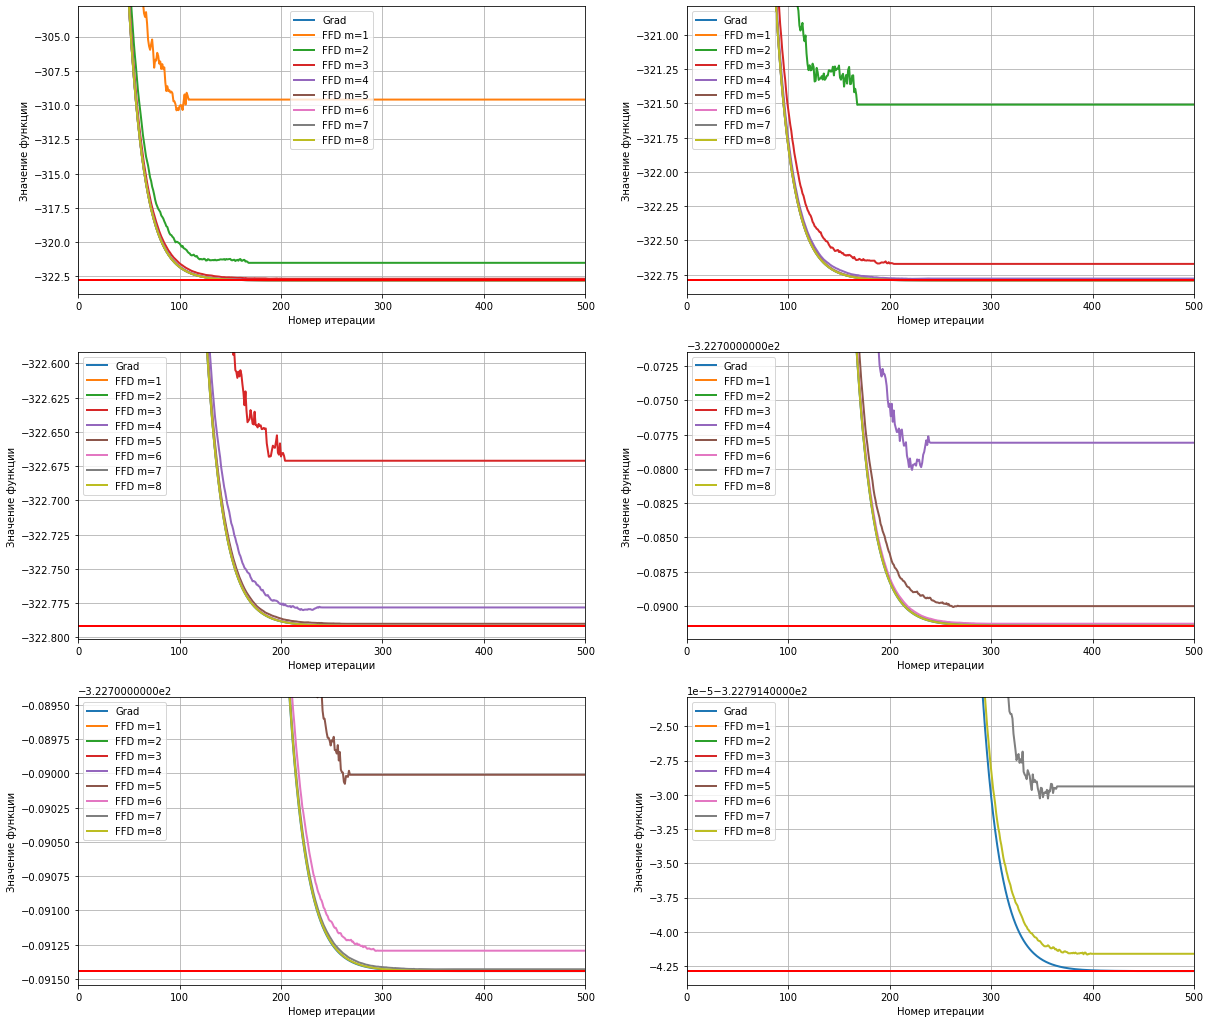

In [1457]:
method_names = ['Grad','FFD m=1','FFD m=2','FFD m=3','FFD m=4', 'FFD m=5', 'FFD m=6', 'FFD m=7', 'FFD m=8']

fig, ax = plt.subplots(3, 2, figsize=(20,18))

for k in range(3):
    for j in range(2):
        for i in range(9):
            ax[k,j].plot([t for t in range(max_iters)], prob_values[i], '-', linewidth=2, label=method_names[i])

        ax[k,j].plot([t for t in range(max_iters)], [prob_solution for i in range(max_iters)],
                     linewidth=2, color='r')
        ax[k,j].grid()
        ax[k,j].legend()
        ax[k,j].set_xlim(0,max_iters)
        ax[k,j].set_ylabel('Значение функции')
        ax[k,j].set_xlabel('Номер итерации')
        
ax[0,0].set_ylim(prob_solution-1, prob_solution+20)
ax[0,1].set_ylim(prob_solution-0.1, prob_solution+2)
ax[1,0].set_ylim(prob_solution-0.01, prob_solution+0.2)
ax[1,1].set_ylim(prob_solution-0.001, prob_solution+0.02)
ax[2,0].set_ylim(prob_solution-0.0001, prob_solution+0.002)
ax[2,1].set_ylim(prob_solution-0.000001, prob_solution+0.00002)

None

Из графиков отчетливо видно, что все аппроксимационные алгоритмы за 500 итераций пришли в стационарный режим, поэтому беря невязку по функции по последней итерации, мы будем получать реальное значение накопленного шума. Проанализируем зависимость от величины шума, вносимого конечной мантиссой:

In [1458]:
gaps = [-prob_solution for i in range(8)]
gaps = np.array(gaps)
deltas = np.zeros(8)

for i in range(1,9):
    gaps[i-1] += prob_values[i][-1]
    deltas[i-1] = 10**(-i)

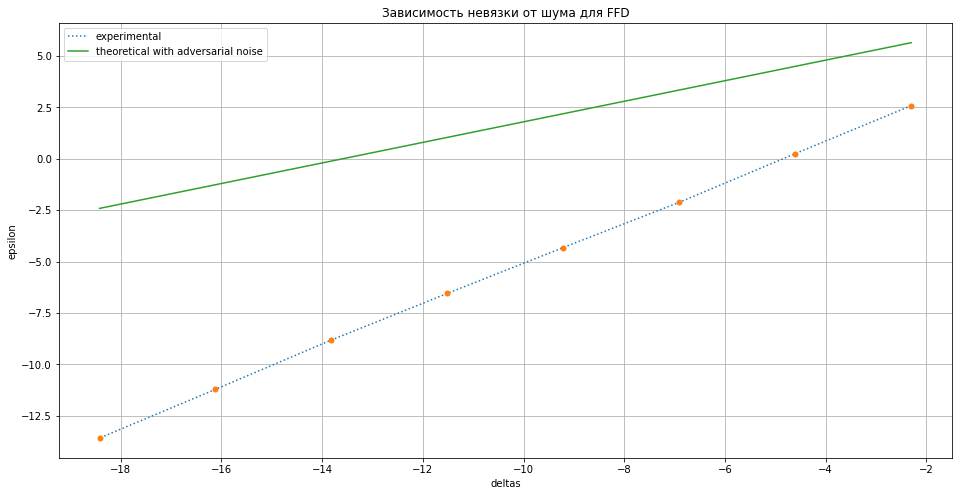

In [1459]:
xaxis = np.linspace(1e-08,1e-01,100)

plt.figure(figsize=(16,8))
plt.plot(np.log(deltas), np.log(gaps), ':', label='experimental')
plt.plot(np.log(deltas), np.log(gaps), 'o', markersize=5)
plt.plot(np.log(xaxis), np.log(experimental_FFD_FWC(xaxis,L,d)), '-', label='theoretical with adversarial noise')
plt.grid()
plt.legend()
plt.xlabel('deltas')
plt.ylabel('epsilon')
plt.title('Зависимость невязки от шума для FFD')
None

Посчитаем наклоны:
1. для теоретической зависимости: 
$\log{\varepsilon}=\log{\sqrt{4Ld\Delta}}=\log{\sqrt{4Ld}}+\log{\sqrt{\Delta}}=\log{\sqrt{4Ld}}+\frac{1}{2}\log{\Delta}$ $\Rightarrow$ $k_{t}=0.5$.
2. для экспериментальной зависимости посчитаем наклон через крайние значения:
$k_{e}=\frac{eps[-1]-eps[0]}{deltas[-1]-deltas[0]}$.

In [1410]:
k_e = (np.log(gaps[-1]) - np.log(gaps[0])) / (np.log(deltas[-1]) - np.log(deltas[0]))
print('Теоретический наклон k_t:', 0.5)
print('Экспериментальный наклон k_e:', k_e)

Теоретический наклон k_t: 0.5
Экспериментальный наклон k_e: 0.1888062792737529


**Вывод**: данные замеры проводились при разных начальных условиях(менялись размерность $d$, константа Липшица $L$, оптимальное значение квадратичной функции), всегда получались практически схожие результаты. В то время, как теории утверждают: 
1. Шум враждебен, в случае FFD зависимость: $\varepsilon\sim O(\sqrt{\Delta})$.
2. Шум случаен, ошибка не накапливается и задачу можно решать со сколь угодной точностью вне зависимости от величины шума.
<br><br>
На деле получилось, что невязка линейно растет с ростом величины шума($\varepsilon\sim O(\Delta^1)$), и вообще говоря мы имеем дело с чем-то средним между враждебным и случайными шумами.

### 3.2. Зависимость $\varepsilon (d)$.

Будем исследовать зависимость при метке конечной мантиссы $m=1$, константе Липшица градиента $L=20$, точку решения задачи $x^*=(1,1,...,1)^T$, меняя при этом размерность пространства: $d=5,10,...,95,100$, на методе `FFD` (прямая покомпонентная разность). Стартовую точку будем сэмплить случайно из равномерного распределения на интервале $[-10,10]$.

Вначале создадим коэффициенты, удовлетворяющие условию выше:

In [1262]:
dims = np.array([i for i in range(5,101)]) # размерность пространства
L = 20 # константа Липшица
m = 1
max_iters = 200

In [1263]:
prob_values = []

for d in tqdm(dims):
    random_state = d
    A, b = quad_coefs(d, L) # создание коэффициентов задачи
    prob = quadratic(A, b, L, m) # создание задачи
    
    x_solution = np.ones(d) # вектор решения
    prob_solution = prob.func(x_solution) # решение
    
    x_start = np.random.uniform(-10, 10, d) # стартовую точку выбираем из равном. распределения от -10 до 10

    values = GD(prob.func, prob.FFD, x_start, 1/L, max_iters) # процедура SGD
    values -= prob_solution # нормирование на оптимум
    
    prob_values.append(values)

  0%|          | 0/96 [00:00<?, ?it/s]

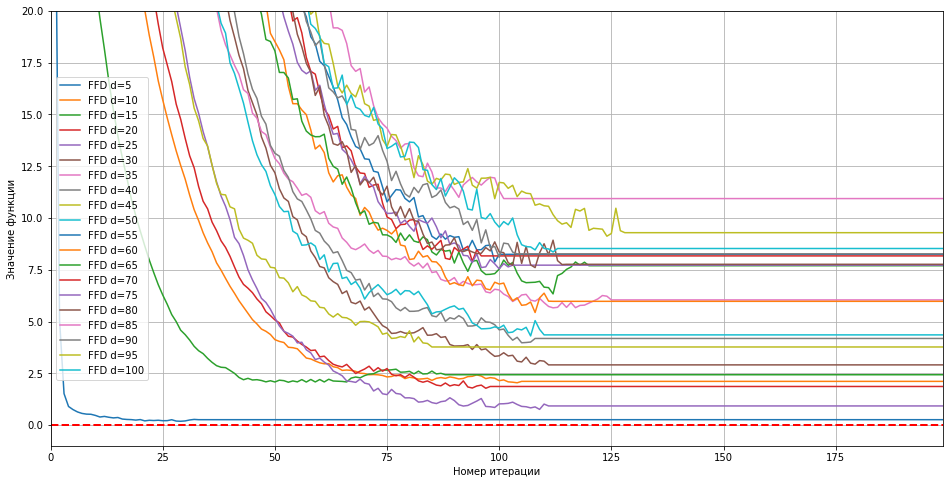

In [1264]:
plt.figure(figsize=(16,8))

for i in range(0,100,5):
    plt.plot([t for t in range(max_iters)], prob_values[i], label='FFD d='+str(dims[i]))

plt.plot([t for t in range(max_iters)], [0 for i in range(max_iters)], 'r--', linewidth=2)
plt.legend()
plt.grid()
plt.xlim(0, max_iters-1)
plt.ylabel('Значение функции')
plt.xlabel('Номер итерации')
plt.ylim(-1,20)
None

Из графиков отчетливо видно, что все аппроксимационные процедуры за 150 итераций пришли в стационарный режим, поэтому беря невязку по функции по последней итерации, мы будем получать реальное значение накопленного шума. Проанализируем зависимость от размерности пространства:

In [1265]:
gaps = np.zeros(96)
for i in range(96):
    gaps[i] = prob_values[i][-1]

Построим линейную аппроксимацию для эксперименатальных данных:

In [1266]:
p = np.polyfit(np.log(dims),np.log(gaps), 1)

А теперь построим график:

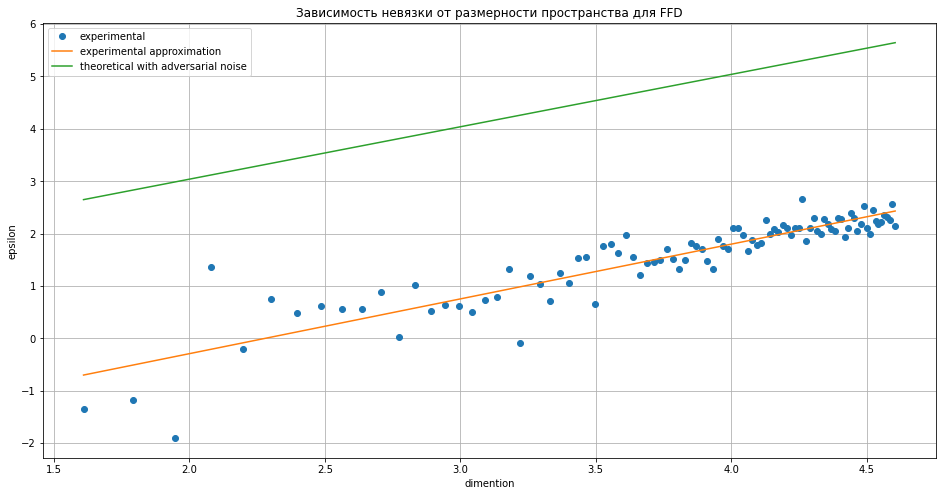

In [1267]:
plt.figure(figsize=(16,8))
plt.grid()

plt.plot(np.log(dims), np.log(gaps), 'o', label='experimental')
plt.plot(np.log(dims), np.polyval(p, np.log(dims)), label='experimental approximation')
plt.plot(np.log(dims), np.log(experimental_FFD_FWC(10**(-m),L,dims)), '-', label='theoretical with adversarial noise')

plt.xlabel('dimention')
plt.ylabel('epsilon')
plt.legend()
plt.title('Зависимость невязки от размерности пространства для FFD')
None

Видно, что экспериментальная зависимость сильно дергается, но это абсолютно нормально, ведь для каждой размерности создавалась задача со своими параметрами. Поэтому как раз была проведена линейная аппроксимация данной зависимости.

Посчитаем наклоны:
1. для теоретической зависимости: 
$\log{\varepsilon}=\log{(R\sqrt{4Ld\Delta})}=\log{(\sqrt{d}\sqrt{4Ld\Delta})}=\log{(d\sqrt{4L\Delta})}
=\log{\sqrt{4L\Delta}}+\log{d}$ $\Rightarrow$ $k_{t}=1$.
2. для экспериментальной зависимости возьмем коэффициент наклона аппроксимации.

In [1269]:
k_e = (np.log(gaps[-1]) - np.log(gaps[0])) / (np.log(dims[-1]) - np.log(dims[0]))
print('Теоретический наклон k_t:', 1)
print('Экспериментальный наклон k_e:', p[0])

Теоретический наклон k_t: 1
Экспериментальный наклон k_e: 1.0451222391376467


**Вывод**: данные замеры проводились при разных начальных условиях(менялись метка конечной мантиссы $m$, константа Липшица $L$, оптимальное значение квадратичной функции), всегда получались практически схожие результаты: экспериментальные данные с хорошей точностью описываются теоретической зависимостью(что и ожидалось). Также данный данный эксперимент еще раз показывает, что шум нельзя считать чисто случайным, ведь ошибка накапливается, причем тем больше, чем больше размерность пространства.

## 4. Исследование FWC

### 4.1. Зависимость $\varepsilon (m)$.

Будем исследовать зависимость при размерности пространства $d=100$, константе Липшица градиента $L=20$, точку решения задачи $x^*=(1,1,...,1)^T$, меняя при этом метку конечной мантиссы в пределе: $m=\overline {1,8}$, на методе `FWC` (прямая покомпонентная разность). Стартовую точку будем сэмплить случайно из равномерного распределения на интервале $[-10,10]$.

Вначале создадим коэффициенты, удовлетворяющие условию выше, после этого по ним создадим квадратичную задачу:

In [1280]:
d = 100 # размерность пространства
L = 20 # константа Липшица
random_state = 2

In [1281]:
A, b = quad_coefs(d, L)
prob = quadratic(A, b, L)

Зная точку оптимума задачи, найдем оптимум для дальнейшего построения графиков:

In [1282]:
x_solution = np.ones(d)
prob_solution = prob.func(x_solution)
print('Оптимум задачи:', prob_solution)

Оптимум задачи: -404.32232014933606


Теперь сэмплируем рандомную стартовую точку:

In [1283]:
x_start = np.random.uniform(-10, 10, d) # стартовую точку выбираем из равномерного распределения от -10 до 10

Запустим процедуру GD для аналитической производной, и для метода `FWC` при различных значениях метки мантиссы, после чего построим графики:

In [1284]:
max_iters=500
prob_values = []

values = GD(prob.func, prob.grad, x_start, 1/L, max_iters)
prob_values.append(values)

for i in trange(1,9):
    prob.m = i
    values = GD(prob.func, prob.FWC, x_start, 1/(L*d), max_iters * d) 
    prob_values.append(values)

  0%|          | 0/8 [00:00<?, ?it/s]

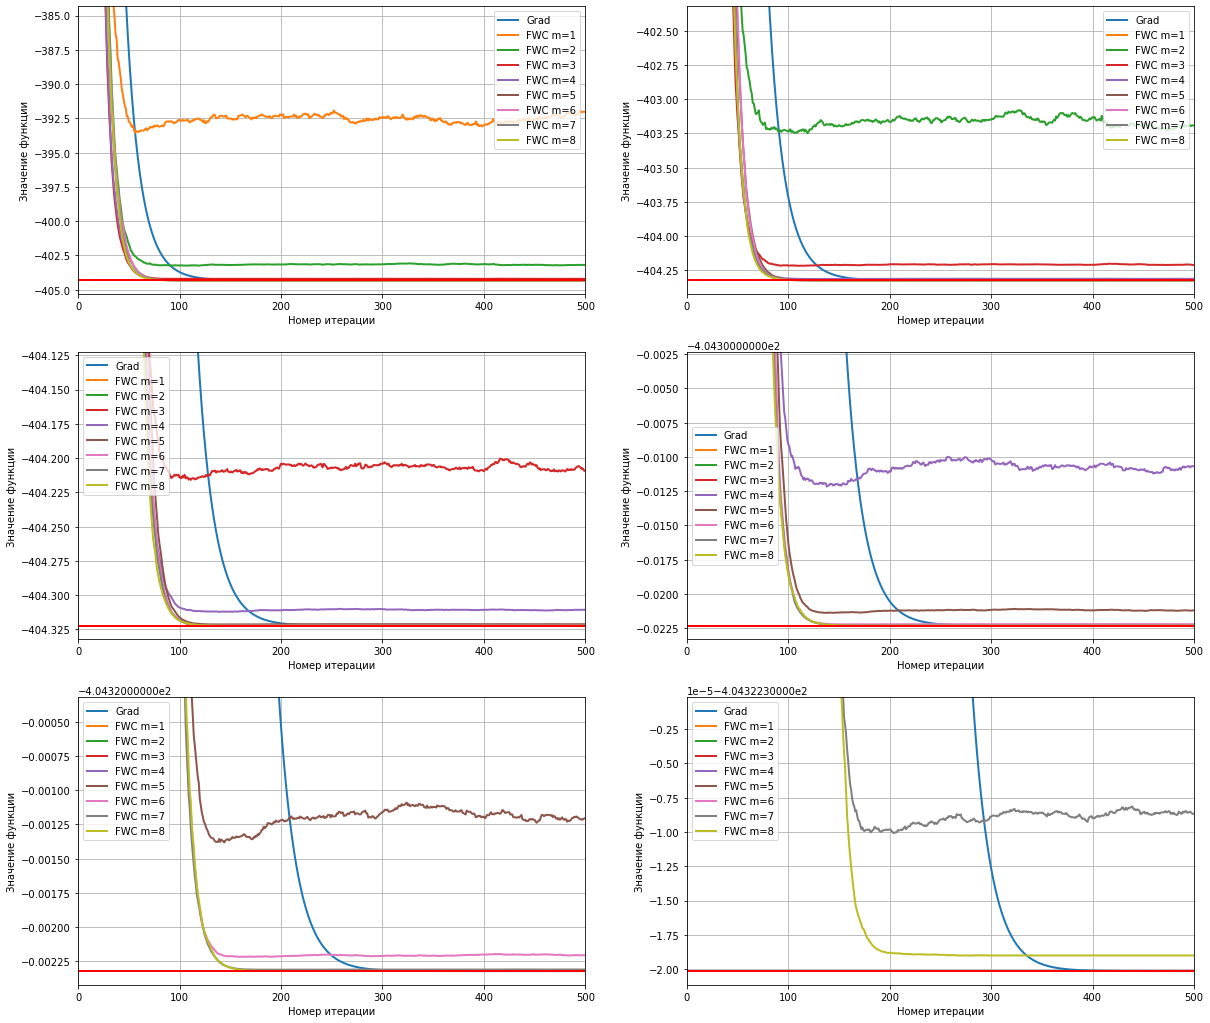

In [1285]:
method_names = ['Grad', 'FWC m=1','FWC m=2','FWC m=3','FWC m=4','FWC m=5','FWC m=6','FWC m=7','FWC m=8']

fig, ax = plt.subplots(3, 2, figsize=(20,18))

for k in range(3):
    for j in range(2):
        ax[k,j].plot([t for t in range(max_iters)], prob_values[0], '-', linewidth=2, label=method_names[0])
        for i in range(1,9):
            ax[k,j].plot([t for t in range(max_iters)], prob_values[i][::d], '-', 
                         linewidth=2, label=method_names[i])

        ax[k,j].plot([t for t in range(max_iters)], [prob_solution for i in range(max_iters)],
                     linewidth=2, color='r')
        ax[k,j].grid()
        ax[k,j].legend()
        ax[k,j].set_xlim(0,max_iters)
        ax[k,j].set_ylabel('Значение функции')
        ax[k,j].set_xlabel('Номер итерации')
        

ax[0,0].set_ylim(prob_solution-1, prob_solution+20)
ax[0,1].set_ylim(prob_solution-0.1, prob_solution+2)
ax[1,0].set_ylim(prob_solution-0.01, prob_solution+0.2)
ax[1,1].set_ylim(prob_solution-0.001, prob_solution+0.02)
ax[2,0].set_ylim(prob_solution-0.0001, prob_solution+0.002)
ax[2,1].set_ylim(prob_solution-0.000001, prob_solution+0.00002)

None

Так как мы берем только итерации с шагом размерности пространства, колебания значений функции при градиентном спуске с использованием `FWC` аппроксимации не видны, однако если посмотреть по всем итерациям, колебания будут(как и должно быть).

Видно, что покомпонентный метод сходится при $\overline{L}$, взятом как среднее с.з. матрицы $A$, в связи с этим метод сходится практически в 2 раза быстрее обычного(с учетом размерности), что согласуется с теорией.

Теперь проанализируем зависимость невязки от величины шума, вносимого конечной мантиссой:

In [1286]:
gaps = [-prob_solution for i in range(8)]
gaps = np.array(gaps)
deltas = np.zeros(8)

for i in range(1,9):
    gaps[i-1] += prob_values[i][-1]
    deltas[i-1] = 10**(-i)

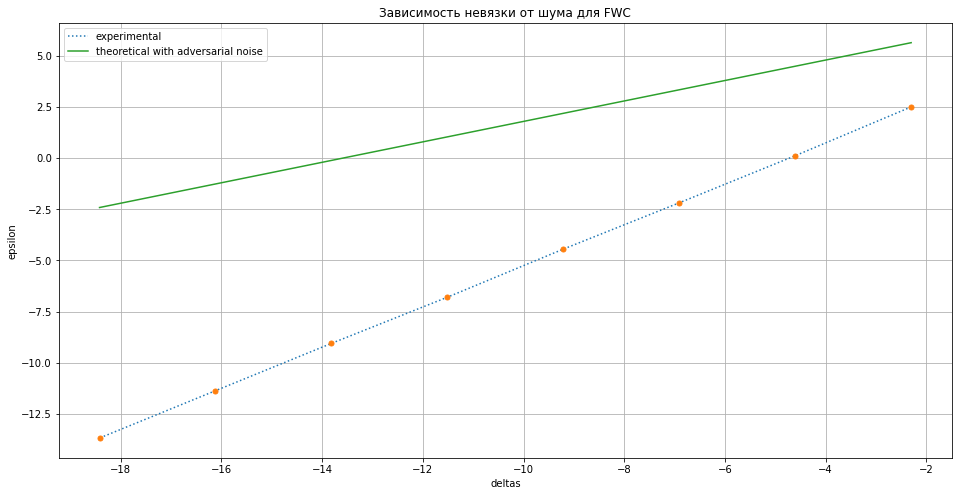

In [1287]:
xaxis = np.linspace(1e-08,1e-01,100)

plt.figure(figsize=(16,8))
plt.plot(np.log(deltas), np.log(gaps), ':', label='experimental')
plt.plot(np.log(deltas), np.log(gaps), 'o', markersize=5)
plt.plot(np.log(xaxis), np.log(experimental_FFD_FWC(xaxis,L,d)), '-', label='theoretical with adversarial noise')
plt.grid()
plt.legend()
plt.xlabel('deltas')
plt.ylabel('epsilon')
plt.title('Зависимость невязки от шума для FWC')
None

Посчитаем наклоны:
1. для теоретической зависимости: 
$\log{\varepsilon}=\log{\sqrt{4Ld\Delta}}=\log{\sqrt{4Ld}}+\log{\sqrt{\Delta}}=\log{\sqrt{4Ld}}+\frac{1}{2}\log{\Delta}$ $\Rightarrow$ $k_{t}=0.5$.
2. для экспериментальной зависимости посчитаем наклон через крайние значения:
$k_{e}=\frac{eps[-1]-eps[0]}{deltas[-1]-deltas[0]}$.

In [1288]:
k_e = (np.log(gaps[-1]) - np.log(gaps[0])) / (np.log(deltas[-1]) - np.log(deltas[0]))
print('Теоретический наклон k_t:', 0.5)
print('Экспериментальный наклон k_e:', k_e)

Теоретический наклон k_t: 0.5
Экспериментальный наклон k_e: 1.00446141240521


**Вывод**: таким образом, результат для метода `FWC` абсолютно аналогичен тому, который был получен для метода `FFD`.

### 4.2. Зависимость $\varepsilon (d)$.

Будем исследовать зависимость при метке конечной мантиссы $m=1$, константе Липшица градиента $L=20$, точку решения задачи $x^*=(1,1,...,1)^T$, меняя при этом размерность пространства: $d=5,10,...,95,100$, на методе `FWC` (прямая покомпонентная разность). Стартовую точку будем сэмплить случайно из равномерного распределения на интервале $[-10,10]$.

Вначале создадим коэффициенты, удовлетворяющие условию выше:

In [1289]:
dims = np.array([i for i in range(5,101)]) # размерность пространства
L = 20 # константа Липшица
m = 1
max_iters = 200

In [1290]:
prob_values = []

for d in tqdm(dims):
    random_state = d
    A, b = quad_coefs(d, L) # создание коэффициентов задачи
    prob = quadratic(A, b, L, m) # создание задачи
    
    x_solution = np.ones(d) # вектор решения
    prob_solution = prob.func(x_solution) # решение
    
    x_start = np.random.uniform(-10, 10, d) # стартовую точку выбираем из равном. распределения от -10 до 10
    
    values = GD(prob.func, prob.FWC, x_start, 2/(L*d), max_iters * d) 
    values -= prob_solution # нормирование на оптимум
    
    prob_values.append(values)

  0%|          | 0/96 [00:00<?, ?it/s]

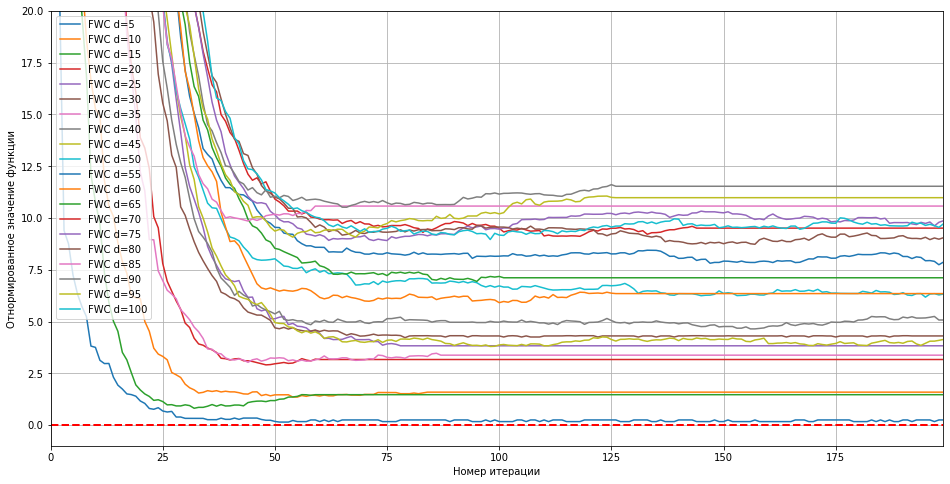

In [1291]:
plt.figure(figsize=(16,8))

for i in range(0,100,5):
    plt.plot([t for t in range(max_iters)], prob_values[i][::dims[i]], label='FWC d='+str(dims[i]))

plt.plot([t for t in range(max_iters)], [0 for i in range(max_iters)], 'r--', linewidth=2)
plt.legend()
plt.grid()
plt.xlim(0, max_iters-1)
plt.ylabel('Отнормированное значение функции')
plt.xlabel('Номер итерации')
plt.ylim(-1,20)
None

Теперь аналогично случаю `FFD` построим график зависимости невязки по функции и размерности пространства: 

In [1292]:
gaps = np.zeros(96)
for i in range(96):
    gaps[i] = prob_values[i][-1]

Построим линейную аппроксимацию для эксперименатальных данных:

In [1293]:
p = np.polyfit(np.log(dims),np.log(gaps), 1)

А теперь построим график:

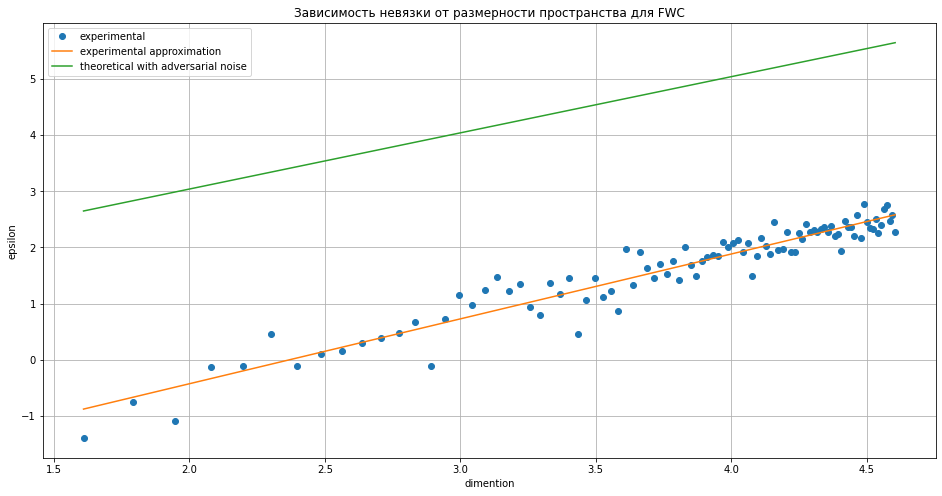

In [1294]:
plt.figure(figsize=(16,8))
plt.grid()

plt.plot(np.log(dims), np.log(gaps), 'o', label='experimental')
plt.plot(np.log(dims), np.polyval(p, np.log(dims)), label='experimental approximation')
plt.plot(np.log(dims), np.log(experimental_FFD_FWC(10**(-m),L,dims)), '-', label='theoretical with adversarial noise')

plt.xlabel('dimention')
plt.ylabel('epsilon')
plt.legend()
plt.title('Зависимость невязки от размерности пространства для FWC')
None

Видно, что экспериментальная зависимость сильно дергается, но это абсолютно нормально, ведь для каждой размерности создавалась задача со своими параметрами. Поэтому как раз была проведена линейная аппроксимация данной зависимости.

Посчитаем наклоны:
1. для теоретической зависимости: 
$\log{\varepsilon}=\log{(R\sqrt{4Ld\Delta})}=\log{(\sqrt{d}\sqrt{4Ld\Delta})}=\log{(d\sqrt{4L\Delta})}
=\log{\sqrt{4L\Delta}}+\log{d}$ $\Rightarrow$ $k_{t}=1$.
2. для экспериментальной зависимости возьмем коэффициент наклона аппроксимации.

In [1295]:
k_e = (np.log(gaps[-1]) - np.log(gaps[0])) / (np.log(dims[-1]) - np.log(dims[0]))
print('Теоретический наклон k_t:', 1)
print('Экспериментальный наклон k_e:', p[0])

Теоретический наклон k_t: 1
Экспериментальный наклон k_e: 1.1546103725006187


**Вывод**: таким образом, результат для метода `FWC` абсолютно аналогичен тому, который был получен для метода `FFD`.

## 5. Исследование FCD

### Зависимость $\varepsilon(\gamma)$.

Вспомним оценку для невязки по функции для метода `FCD`:
$$\varepsilon=R\cdot\Vert g(x)-\nabla{f(x)}\Vert\leq R\sqrt{d}(\frac{M\gamma^2}{6}+\frac{\Delta}{\gamma})$$
В случае квадратичной задачи константа Липшица гессиана $M=0$. Тогда получаем оценку:
$$\varepsilon \sim \frac{R\sqrt{d}\Delta}{\gamma} \sim \frac{d\Delta}{\gamma}$$

Видно, что данная оценка сильно отличается от оценки для случая `FFD`, ведь тут все проще: если мы хотим уменьшить невязку по функции, мы можем просто увеличить параметр аппроксимации $\gamma$. Осталось проверить это экспериментально.

Будем исследовать зависимость $\varepsilon(\gamma)$ при размерности пространства $d=100$, константе Липшица градиента $L=20$, точке решения задачи $x^*=(1,1,...,1)^T$, метке конечной мантиссы $m=1$, на методе `FCD` (конечная центральная разность). Стартовую точку будем сэмплить случайно из равномерного распределения на интервале $[-10,10]$.

Вначале создадим коэффициенты, удовлетворяющие условию выше, после этого по ним создадим квадратичную задачу:

In [1348]:
d = 100 # размерность пространства
L = 20 # константа Липшица
random_state = 1
m = 1

In [1349]:
A, b = quad_coefs(d, L)
prob = quadratic(A, b, L,m)

Зная точку оптимума задачи, найдем оптимум для дальнейшего построения графиков:

In [1350]:
x_solution = np.ones(d)
prob_solution = prob.func(x_solution)
print('Оптимум задачи:', prob_solution)

Оптимум задачи: -452.01525131937757


Теперь сэмплируем рандомную стартовую точку:

In [1351]:
x_start = np.random.uniform(-10, 10, d) # стартовую точку выбираем из равномерного распределения от -10 до 10

Запустим процедуру GD для аналитической производной, и для конечной прямой суммы при различных значениях $\gamma$, после чего построим графики:

In [1352]:
max_iters=500
prob_values = []

values = GD(prob.func, prob.grad, x_start, 1/L, max_iters)
prob_values.append(values)


gammas = np.array([0.1, 1, 5, 10, 20, 30, 40, 50, 100])
for gamma in tqdm(gammas):
    prob.gamma = gamma
    values = GD(prob.func, prob.FCD, x_start, 1/L, max_iters)
    prob_values.append(values)


  0%|          | 0/9 [00:00<?, ?it/s]

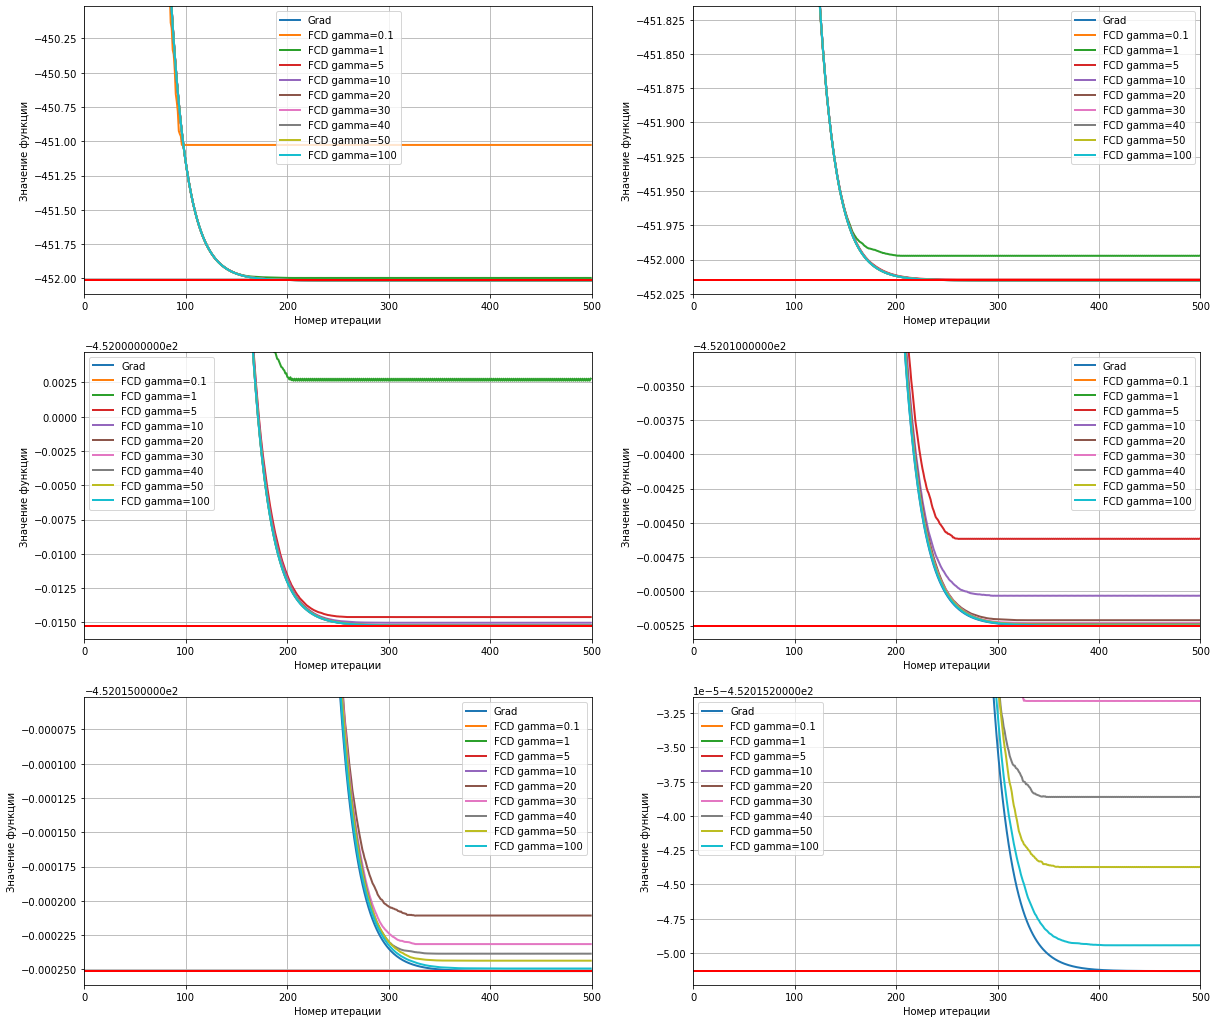

In [1353]:
method_names = ['Grad','FCD gamma=0.1','FCD gamma=1','FCD gamma=5',
                'FCD gamma=10','FCD gamma=20','FCD gamma=30','FCD gamma=40',
                'FCD gamma=50', 'FCD gamma=100']

fig, ax = plt.subplots(3, 2, figsize=(20,18))

for k in range(3):
    for j in range(2):
        for i in range(10):
            ax[k,j].plot([t for t in range(max_iters)], prob_values[i], '-', linewidth=2, label=method_names[i])

        ax[k,j].plot([t for t in range(max_iters)], [prob_solution for i in range(max_iters)],
                     linewidth=2, color='r')
        ax[k,j].grid()
        ax[k,j].legend()
        ax[k,j].set_xlim(0,max_iters)
        ax[k,j].set_ylabel('Значение функции')
        ax[k,j].set_xlabel('Номер итерации')
        
ax[0,0].set_ylim(prob_solution-0.1, prob_solution+2)
ax[0,1].set_ylim(prob_solution-0.01, prob_solution+0.2)
ax[1,0].set_ylim(prob_solution-0.001, prob_solution+0.02)
ax[1,1].set_ylim(prob_solution-0.0001, prob_solution+0.002)
ax[2,0].set_ylim(prob_solution-0.00001, prob_solution+0.0002)
ax[2,1].set_ylim(prob_solution-0.000001, prob_solution+0.00002)

None

**Вывод**: полученные в эксперименте результаты полностью согласуются с теорией. Действительно, для квадратичных задач(константа Липшица Гессиана $M=0$) при использовании центральной суммы можно брать большой отступ $\gamma$, тем самым уменьшая влияние шума на невязку по функции $\varepsilon$. В таких вырожденных задачах($M=0$) алгоритмы с центральной суммой показывают намного лучше результат, чем аналогичные алгоритмы с прямой суммой(при $m=1$ разница между работой алгоритма `FFD` и работой алгоритма `FWC`(с $\gamma=100$) в плане точности колоссальна).

## 5. Исследование FSSG2

### 5.1. Зависимость $\varepsilon (m)$.

Будем исследовать зависимость при размерности пространства $d=100$, константе Липшица градиента $L=20$, точку решения задачи $x^*=(1,1,...,1)^T$, меняя при этом метку конечной мантиссы в пределе: $m=\overline {1,8}$, на методе `FSSG2` (прямая рандомизация на l2 сфере). Стартовую точку будем сэмплить случайно из равномерного распределения на интервале $[-10,10]$.

Вначале создадим коэффициенты, удовлетворяющие условию выше, после этого по ним создадим квадратичную задачу:

In [1460]:
d = 100 # размерность пространства
L = 20 # константа Липшица
random_state = 1

In [1461]:
A, b = quad_coefs(d, L)
prob = quadratic(A, b, L)

Зная точку оптимума задачи, найдем оптимум для дальнейшего построения графиков:

In [1462]:
x_solution = np.ones(d)
prob_solution = prob.func(x_solution)
print('Оптимум задачи:', prob_solution)

Оптимум задачи: -397.070187456635


Теперь сэмплируем рандомную стартовую точку:

In [1463]:
x_start = np.random.uniform(-10, 10, d) # стартовую точку выбираем из равномерного распределения от -10 до 10

Запустим процедуру GD для аналитической производной, и для метода `FSSG_L2` при различных значениях метки мантиссы, после чего построим графики:

In [1474]:
max_iters=500
prob_values = []

values = GD(prob.func, prob.grad, x_start, 1/L, max_iters)
prob_values.append(values)

for i in trange(1,9):
    prob.m = i
    values = GD(prob.func, prob.FSSG2, x_start, 1/(L*d), max_iters * d) 
    prob_values.append(values)

  0%|          | 0/8 [00:00<?, ?it/s]

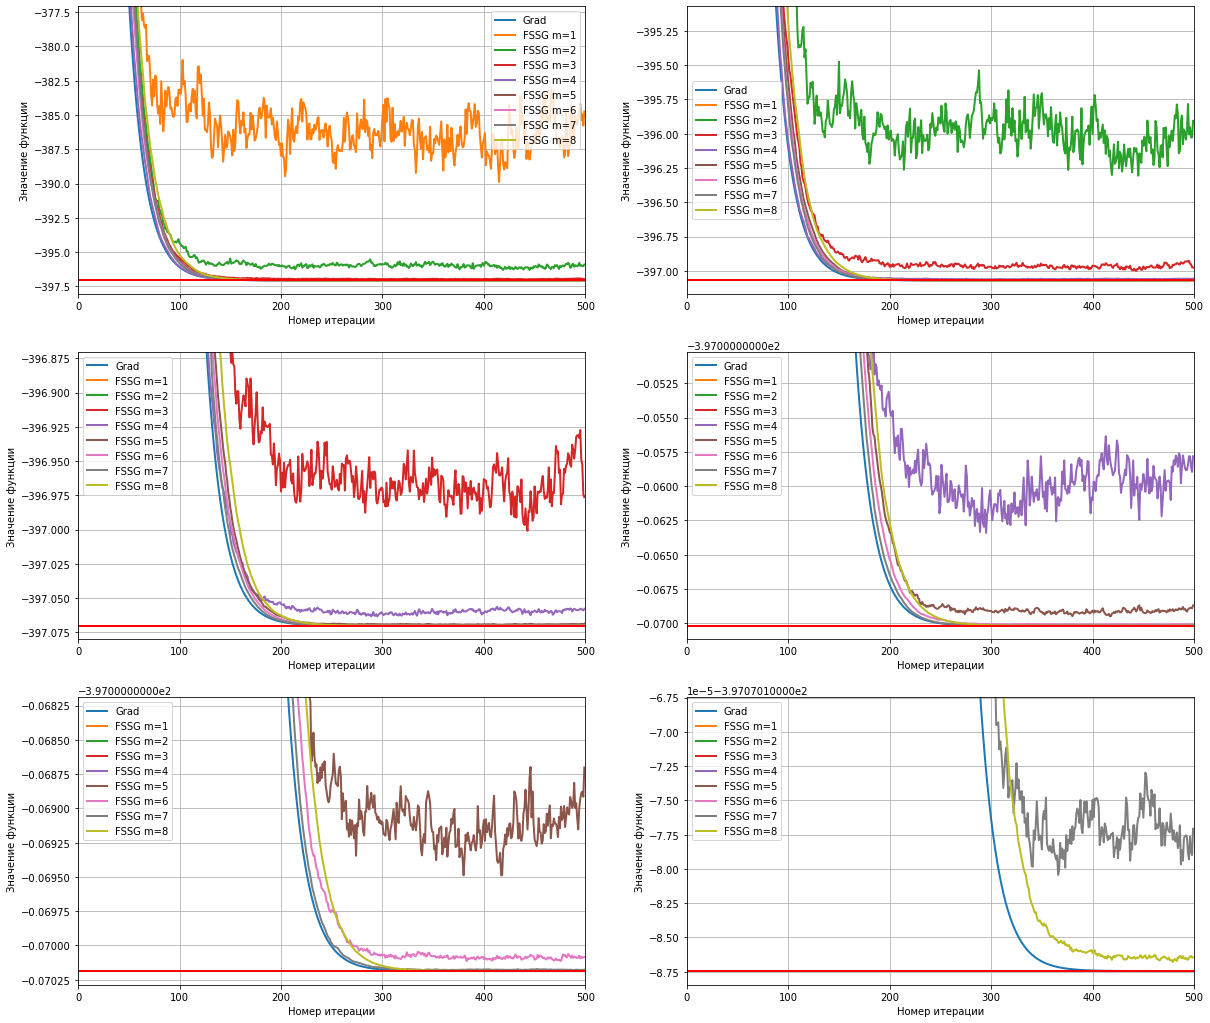

In [1475]:
method_names = ['Grad', 'FSSG m=1','FSSG m=2','FSSG m=3','FSSG m=4','FSSG m=5','FSSG m=6','FSSG m=7','FSSG m=8']

fig, ax = plt.subplots(3, 2, figsize=(20,18))

for k in range(3):
    for j in range(2):
        ax[k,j].plot([t for t in range(max_iters)], prob_values[0], '-', linewidth=2, label=method_names[0])
        for i in range(1,9):
            ax[k,j].plot([t for t in range(max_iters)], prob_values[i][::d], '-', 
                         linewidth=2, label=method_names[i])

        ax[k,j].plot([t for t in range(max_iters)], [prob_solution for i in range(max_iters)],
                     linewidth=2, color='r')
        ax[k,j].grid()
        ax[k,j].legend()
        ax[k,j].set_xlim(0,max_iters)
        ax[k,j].set_ylabel('Значение функции')
        ax[k,j].set_xlabel('Номер итерации')
        

ax[0,0].set_ylim(prob_solution-1, prob_solution+20)
ax[0,1].set_ylim(prob_solution-0.1, prob_solution+2)
ax[1,0].set_ylim(prob_solution-0.01, prob_solution+0.2)
ax[1,1].set_ylim(prob_solution-0.001, prob_solution+0.02)
ax[2,0].set_ylim(prob_solution-0.0001, prob_solution+0.002)
ax[2,1].set_ylim(prob_solution-0.000001, prob_solution+0.00002)

None

### 5.2. Зависимость $\varepsilon (d)$.